# Super-Resolution

This example demonstrates the use of neural operators for
super-resolution.

We will employ the FLAME dataset, a set of flow samples of size 32x32 that
should be up-sampled to 128x128.

> Download the data set manually from
[Kaggle](https://www.kaggle.com/competitions/2023-flame-ai-challenge/data)
and put it into the `data/flame` directory.

## Setup

Import modules.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from continuity.data.flame import FlameDataLoader, FlameDataSet
from continuity.operators import DeepONet
from continuity.plotting import plot

In [3]:
torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

## Dataset

We create a `FlameDataSet` that exports batches of samples
from the FLAME data set. It is split into `train`/`val` sets
and has four channels `ux`, `uy`, `uz`, and `rho`, where we use only
channel `ux` in this example.

In [4]:
loader = FlameDataLoader(path='../data/flame')
dataset = FlameDataSet(loader, size=1, split="train", channels=["ux"])
print(f"Dataset contains {len(dataset)} batches of batch size {dataset.batch_size}.")

# Extract first sample
first_batch = dataset[0]
x, u, y, v = [a[0] for a in first_batch]
print(f"Shapes of first sample: x={x.shape}, u={u.shape}, y={y.shape}, v={v.shape}")

Dataset contains 1 batches of batch size 32.
Shapes of first sample: x=torch.Size([256, 2]), u=torch.Size([256, 1]), y=torch.Size([16384, 2]), v=torch.Size([16384, 1])


# Plotting

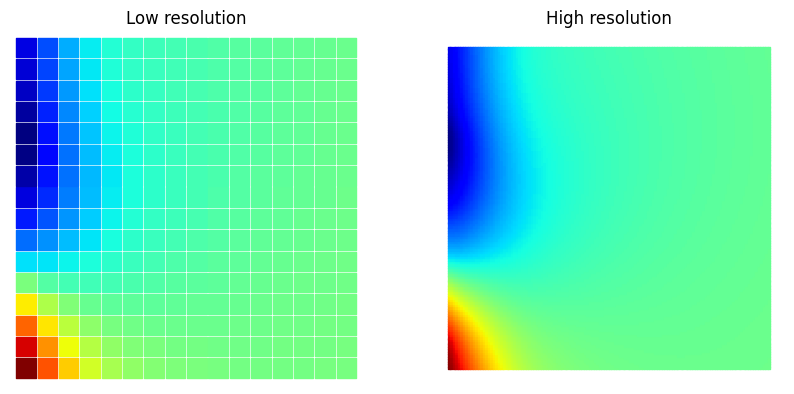

In [5]:
def plot_lr_hr(x, u, y, v):
    _, ax = plt.subplots(1, 2, figsize=(10, 5))
    plot(x, u, ax=ax[0])
    plot(y, v, ax=ax[1])
    ax[0].set_title("Low resolution")
    ax[1].set_title("High resolution")
    ax[0].axis('off')
    ax[1].axis('off')

plot_lr_hr(x, u, y, v)

# Operator

We define a `DeepONet` to map the low-resolution data to a continuous function,
which we then sample to obtain the high-resolution data.

In [6]:
operator = DeepONet(
    num_sensors=dataset.num_sensors,
    coordinate_dim=dataset.coordinate_dim,
    num_channels=dataset.num_channels,
)

v = operator(x, u, y)
print(f"Output shape: v={v.shape}")

Output shape: v=torch.Size([16384, 1])


# Training

In [7]:
optimizer = torch.optim.Adam(operator.parameters(), lr=1e-3)
operator.compile(optimizer)
operator.fit(dataset, epochs=1000)

Model parameters: 15184
Epoch 1000:  loss = 2.3384e-03  (87.57 it/s)


# Evaluating

We can evaluate the trained operator at arbitrary positions,
so let's plot the mapped function with contours sampled on a fine meshgrid
with 200 positions (instead of 128 we trained on)!

Text(0.5, 1.0, 'Continuous')

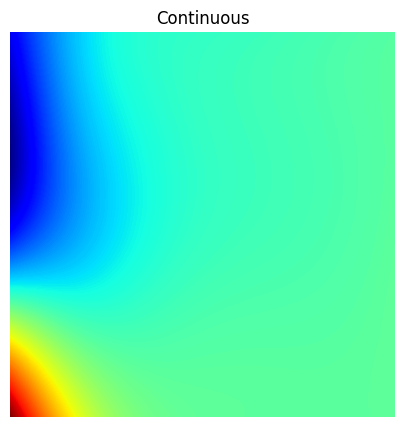

In [8]:
a = torch.linspace(-1, 1, 200) # != 128 (!)
X, Y = torch.meshgrid(a, a, indexing='ij')

yy = torch.stack([X.flatten(), Y.flatten()], dim=1)
vv = operator(x, u, yy)
vv = vv.detach().reshape(X.shape)

fig, ax = plt.subplots(figsize=(5, 5))
ax.contourf(X, Y, vv, levels=1000, cmap='jet')
ax.set_aspect('equal')
ax.axis('off')
ax.set_title("Continuous")